# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [ ]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [ ]:
# Download the data
if not os.path.exists('/content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
if not os.path.exists('/content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

--2024-02-14 22:51:47--  https://www.cs.cmu.edu/~deva/data/aerialseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92160128 (88M)
Saving to: ‘/content/aerialseq.npy’

/content/aerialseq. 100%[===================>]  87.89M   670KB/s    in 2m 35s  

2024-02-14 22:54:23 (582 KB/s) - ‘/content/aerialseq.npy’ saved [92160128/92160128]

--2024-02-14 22:54:23--  https://www.cs.cmu.edu/~deva/data/antseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M)
Saving to: ‘/content/antseq.npy’

/content/antseq.npy 100%[===================>]  62.50M   500KB/s    in 98s     

2024-02-14 22:56:03 (650 KB/s) - ‘/content/antseq.npy’ saved [65536128/65536128]



# Q3: Affine Motion Subtraction

## Q3.1: Dominant Motion Estimation (15 points)

In [ ]:
from scipy.interpolate import RectBivariateSpline

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
    # ===== your code here! =====
    # Create an interpolating spline for each image.
     # Image dimensions
    height, width = It.shape

    # Coordinates of pixels in It
    Y, X = np.mgrid[0:height, 0:width]

    # Create spline objects for image interpolation
    spline_It = RectBivariateSpline(np.arange(height), np.arange(width), It)
    spline_It1 = RectBivariateSpline(np.arange(height), np.arange(width), It1)

    for _ in range(num_iters):
        # Warp the coordinates
        warped_X = M[0, 0] * X + M[0, 1] * Y + M[0, 2]
        warped_Y = M[1, 0] * X + M[1, 1] * Y + M[1, 2]
        # grad
        Ix = spline_It1.ev(warped_Y, warped_X, dy=1)
        Iy = spline_It1.ev(warped_Y, warped_X, dx=1)
        # Flatten grad
        need = (warped_X >= 0) & (warped_X < width) & (warped_Y >= 0) & (warped_Y < height)
        Ix = Ix[need]
        Iy = Iy[need]
        X_flat = X[need]
        Y_flat = Y[need]
        #A matrix
        A = np.vstack([Ix*X_flat, Ix*Y_flat, Ix, Iy*X_flat, Iy*Y_flat, Iy]).T
        # error
        It_warped = spline_It.ev(Y_flat, X_flat)
        It1_warped = spline_It1.ev(warped_Y[need], warped_X[need])
        b = It_warped - It1_warped
        # Solve for delta_p using least squares
        delta_p, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
        # Update M using delta_p
        delta_M = np.array([[delta_p[0], delta_p[1], delta_p[2]], [delta_p[3], delta_p[4], delta_p[5]]])
        M[:2, :3] += delta_M

        # Check for convergence
        if np.linalg.norm(delta_p) < threshold:
            break
    # ===== End of code =====
    return M

## Debug Q3.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

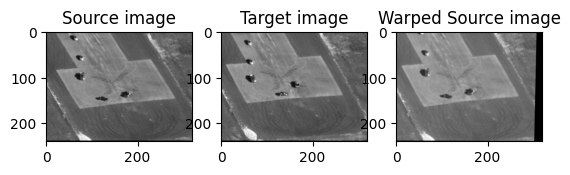

In [ ]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("/content/aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = LucasKanadeAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

# Q3.2: Moving Object Detection (10 points)

In [ ]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====
    M = LucasKanadeAffine(It, It1, threshold, num_iters)
    imH, imW = It.shape
    #It_warped = scipy.ndimage.affine_transform(It, -M, offset=0.0, output_shape=None)
    #It_warped = cv2.warpAffine(It, M, )
    It_warped = affine_transform(It, -M, offset=0.0, output_shape=None, order=1)
    diff = np.absolute(It_warped - It)
    mask[diff > tolerance] = 0
    mask[diff < tolerance] = 1

    mask = binary_erosion(mask)
    mask = binary_dilation(mask, iterations=1)
    # ===== End of code =====

    return mask


## Q3.3: Tracking with affine motion (10 points)

In [ ]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    masks =[]
    It = seq[:,:,0]
    # ===== your code here! =====
    for i in tqdm(range(1, seq.shape[2])):
        It = seq[:, :, i-1]
        It1 = seq[:, :, i]
        # Compute the mask for moving objects
        mask= SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)

    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

## Q3.3 (a) - Track Ant Sequence

In [ ]:
seq = np.load("/content/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2
tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [01:32<00:00,  1.34it/s]


Ant Sequence takes 92.856568 seconds


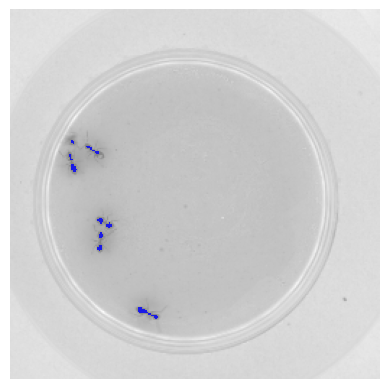

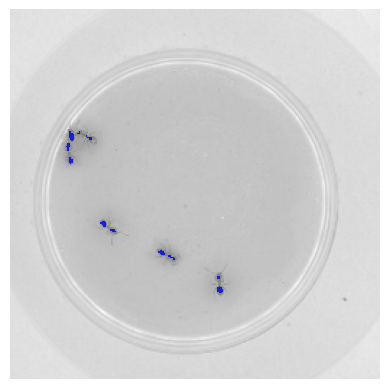

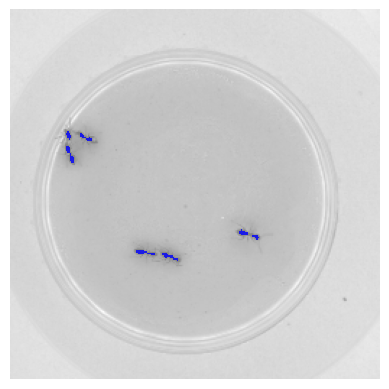

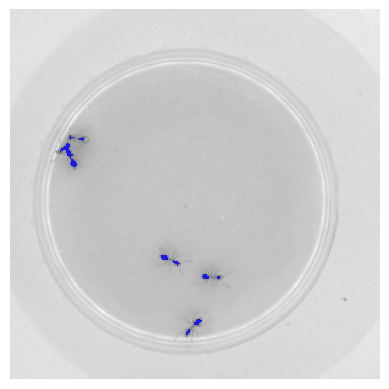

In [ ]:
frames_to_save = [29, 59, 89, 119]
#frames_to_save = [0, 1, 2, 3]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


### Q3.3 (b) - Track Aerial Sequence

In [ ]:
seq = np.load("/content/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.3

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))


100%|██████████| 149/149 [03:57<00:00,  1.60s/it]


Ant Sequence takes 237.973585 seconds


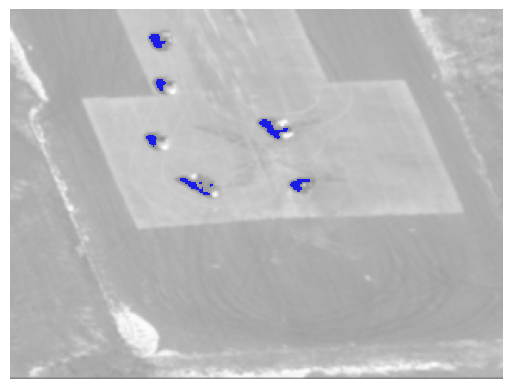

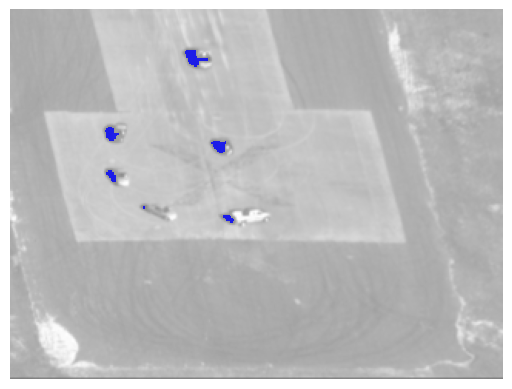

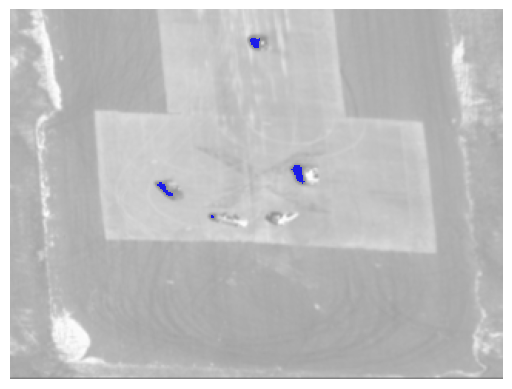

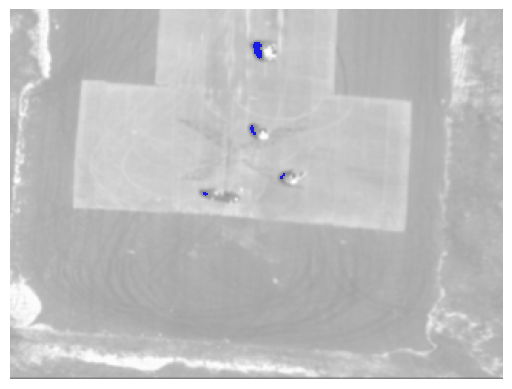

In [ ]:
frames_to_save = [29, 59, 89, 119]
#frames_to_save = [0,1,2,3]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')




